<a href="https://colab.research.google.com/github/altayavci/time-series/blob/main/stockpred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [ ]:
start_date="2002-04-29"
end_date="2022-04-29"

In [ ]:
df = pdr.get_data_yahoo("TSLA",start_date,end_date)
#data_reader  yfinance api'sini kullanıyor arkada

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [ ]:
df.reset_index(inplace=True)

df=df.drop(["Adj Close"],axis=1)

df.Date=pd.to_datetime(df.Date)


In [ ]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

In [ ]:
df.head()


,Date,Open,High,Low,Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500


In [ ]:
df.shape

(2980, 6)

In [ ]:
ma_100days=df.Close.rolling(window=100).mean()
ma_200days=df.Close.rolling(window=200).mean()
#moving average icin (100 günlük) rolling methodunu kullanıcaz arimadaki gibi 
#ilk 100 terim na olcak cünkü 0. index ile 100. indexin meanini alıp 100. indexe atıyor, bu durumda 0. index bos kalıyor.
#200 günlük hareketli ortalama (moving average)

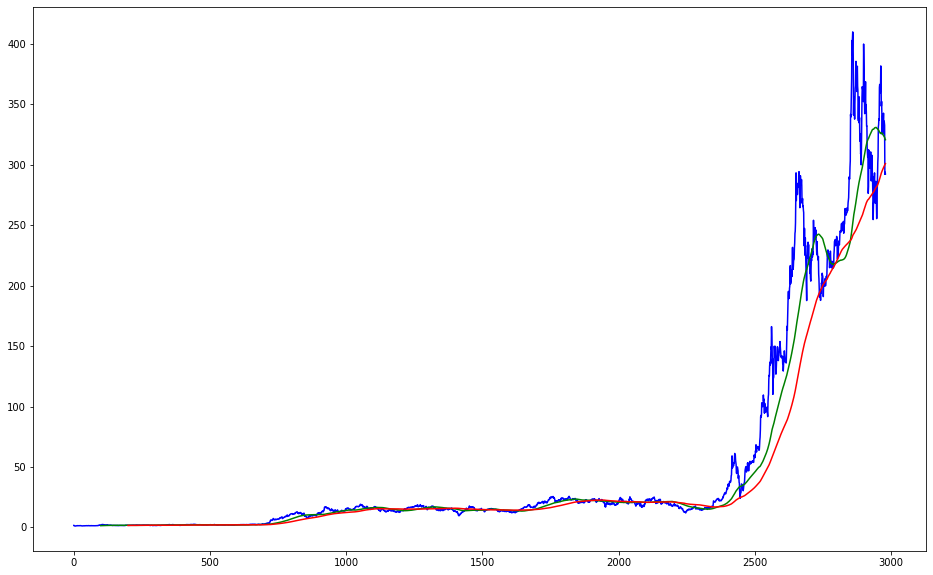

In [ ]:
fig=plt.figure(figsize=(16,10))
plt.plot(df.Close,color="blue")
plt.plot(ma_100days,color="green")
plt.plot(ma_200days,color="red")
plt.show()
#sonuca bakarsak göreceğiz ki ilk 0'dan 99. indekse kadar bir boşluk olcak, sonrasında grafikte ma yani (hareketli ortalama)'yı görebileceğiz
#bu da 100 günlük ve 200 günlük hareketli ortalama demektir 

In [ ]:
data_training=pd.DataFrame(df.Close[0:int(df.shape[0]*0.7)])
data_testing=pd.DataFrame(df.Close[int(df.shape[0]*0.7):int(df.shape[0])])

#simdi de training ve testing icin datayı bölelim
#fakat bu zaman serisi analizi oldugundan train_test_split methodunu kullanmıcaz ! 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
ct=MinMaxScaler(feature_range=(0,1))
data_training_scaled=ct.fit_transform(data_training)

#normalizasyon ve scaling icin minmaxscaler kullandık. sebebini tam bilmiyorum ama 0 ile 1 arasında scale ediyor
#standartscaler z^2 i kullanıyordu yani -3 ile 3 arası 

In [ ]:
X_train,y_train=[],[]

for j in range(100,data_training_scaled.shape[0]):

    X_train.append(data_training_scaled[j-100:j])
    #0-100,1-101,2-102. +...n - n+100. indeksli değerler totalde data_training.shape[0] kadar satıra kaydediliyor
    y_train.append(data_training_scaled[j,0])
    #j,0 denmesnin sebebi her satırda k'dan k+100 indeksli close değeri oldugundan her satırdaki sadece k. indeksli elemanı alma
X_train,y_train=np.array(X_train),np.array(y_train)

In [ ]:
past_100days=data_training.tail(100)

df_last=past_100days.append(data_testing,ignore_index=True)
#bunları yapmamızın sebebi, prediction icin. data_testing'in ilk indexi k olsun, data_training.tail() dediğimizde en başta belirlen(length-5. index)indeks de k-100. indekstir. 
#rolling ile ilk 100 değeri atladğımız icin past_100days'i de test datasetimize ekliyoruz .

In [ ]:
input_data=ct.fit_transform(df_last)

X_test,y_test=[],[]

for k in range(100,input_data.shape[0]):

    X_test.append(input_data[k-100:k])
    y_test.append(input_data[k,0])

X_test,y_test=np.array(X_test),np.array(y_test)

In [ ]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
#Model kısmına geciyoz (ml model)

In [ ]:
model=Sequential()

model.add(LSTM(units=50,activation="tanh",return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
#bura shape'te 1 dememizin sebebi range'i yüzden baslatınca her satırda aslında 0-100,100-200. elemanlar allocate edildi bu sebeple input_shape 100 olmalıydı
model.add(LSTM(units=60,activation="tanh",return_sequences=True))
model.add(Dropout(0.3))
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

model.add(LSTM(units=80,activation="tanh",return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation="tanh"))
model.add(Dropout(0.5))

model.add(Dense(units=1)) 
#1 parametre tahmini yapmak istediğimiz icin 1 dedik (closing price o parametre ), bütün layerları bir araya getiriyor (4)


#https://www.koreascience.or.kr/article/JAKO202025356104177.pdf

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 100, 50)           10400     
                                                                 
 dropout_16 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_17 (LSTM)              (None, 100, 60)           26640     
                                                                 
 dropout_17 (Dropout)        (None, 100, 60)           0         
                                                                 
 lstm_18 (LSTM)              (None, 100, 80)           45120     
                                                                 
 dropout_18 (Dropout)        (None, 100, 80)           0         
                                                                 
 lstm_19 (LSTM)              (None, 120)              

In [ ]:
X_train.shape

(3425, 100, 1)

In [ ]:
X_train.shape

(3425, 100, 1)

In [ ]:
model.compile(optimizer="adam",loss="mean_squared_error",metrics=['mean_absolute_error','accuracy'])

history=model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test))

model.save("keras_model.h5")

#drive'da yeni save edileni yüklemeyi unutma 
#tekrar calıstır knk 

Epoch 1/10
108/108 [==============================] - 60s 365ms/step - loss: 0.0094 - mean_absolute_error: 0.0556 - val_loss: 0.0010 - val_mean_absolute_error: 0.0212
Epoch 2/10
108/108 [==============================] - 38s 348ms/step - loss: 0.0036 - mean_absolute_error: 0.0369 - val_loss: 0.0132 - val_mean_absolute_error: 0.0878
Epoch 3/10
108/108 [==============================] - 38s 351ms/step - loss: 0.0035 - mean_absolute_error: 0.0372 - val_loss: 0.0013 - val_mean_absolute_error: 0.0230
Epoch 4/10
108/108 [==============================] - 39s 357ms/step - loss: 0.0030 - mean_absolute_error: 0.0343 - val_loss: 0.0013 - val_mean_absolute_error: 0.0245
Epoch 5/10
108/108 [==============================] - 38s 348ms/step - loss: 0.0027 - mean_absolute_error: 0.0338 - val_loss: 0.0034 - val_mean_absolute_error: 0.0415
Epoch 6/10
108/108 [==============================] - 37s 344ms/step - loss: 0.0026 - mean_absolute_error: 0.0328 - val_loss: 0.0081 - val_mean_absolute_error: 0.061

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from keras.models import load_model

model=load_model("keras_model.h5")

In [ ]:
yhat=model.predict(X_test)

28/28 [==============================] - 4s 91ms/step


In [ ]:
scale_coeff=1/ct.scale_
yhat*=scale_coeff
y_test*=scale_coeff

#şimdi de scale ettiğimiz değerleri eski haline getirmek icin bir katsayı bulup kendi değerleriyle carpacaz

In [ ]:
df.Close

0         1.592667
1         1.588667
2         1.464000
3         1.280000
4         1.074000
           ...    
2975    335.016663
2976    332.673340
2977    292.140015
2978    293.836670
2979    292.503326
Name: Close, Length: 2980, dtype: float64

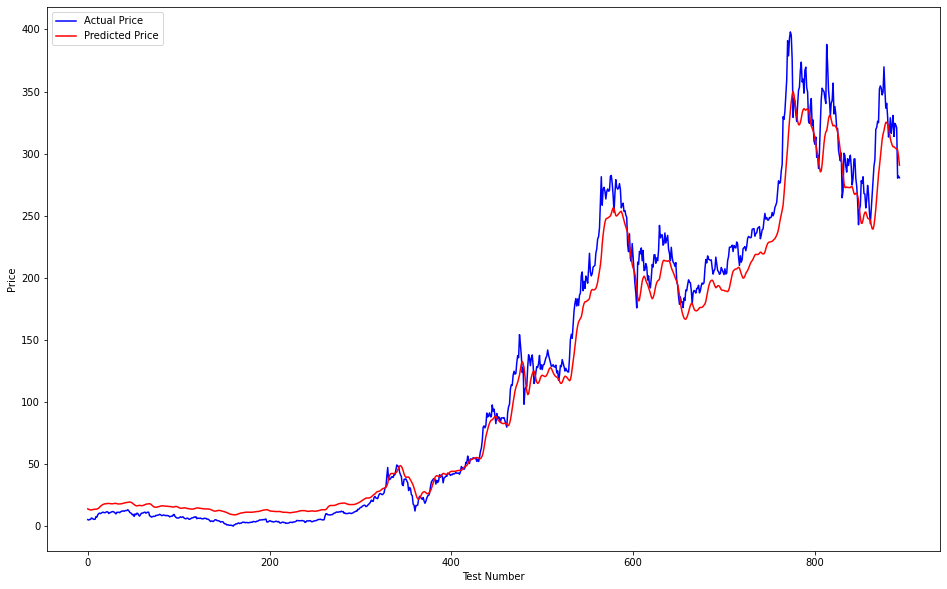

In [ ]:
fig=plt.figure(figsize=(16,10))
plt.plot(y_test,color="blue",label="Actual Price")
plt.plot(yhat,color="red",label="Predicted Price")
plt.xlabel("Test Number")
plt.ylabel("Price")
plt.legend()